In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

In [2]:
# Set the directory paths for training and testing images
train_dir ="./Data/Face Mask Dataset/train"
test_dir ="./Data/Face Mask Dataset/test"

In [3]:
# Set the input shape
input_shape = (128, 128, 3)
batch_size = 32

In [4]:
# Use ImageDataGenerator for data augmentation
data_generator = ImageDataGenerator(rescale=1./255)

In [5]:
# Load the training images
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1982 images belonging to 2 classes.


In [6]:
# Load the test images
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1743 images belonging to 2 classes.


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Define the CNN model architecture up to the feature extraction layer
model = Sequential([
    Conv2D(32, (3, 3), input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5)
])

In [10]:
# Extract features from training images 
train_features = model.predict(train_generator)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features for KNN
train_labels = train_generator.classes

62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step


In [11]:
# Extract features from test images 
test_features = model.predict(test_generator)
test_features = test_features.reshape(test_features.shape[0], -1)
test_labels = test_generator.classes

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step


In [12]:
# Initialize and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=7)  # You can adjust n_neighbors as needed
knn_classifier.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=7)

In [13]:
# Make predictions on the test data
test_predictions = knn_classifier.predict(test_features)

In [14]:
# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 65.52%


In [15]:
# Save the Keras CNN model as an .h5 file
model.save('models/cnn_Feature_Extractor2.h5')

In [16]:
# Save the trained KNN model
joblib.dump(knn_classifier, 'models/knn_classifier.pkl')

['models/knn_classifier.pkl']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


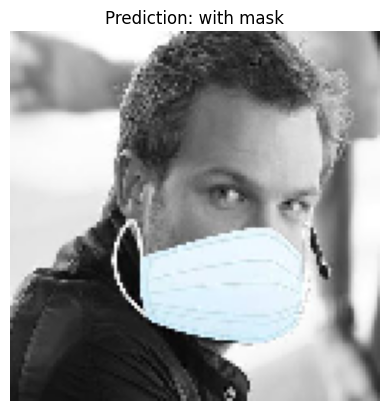

The image is classified as: with mask


In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved models
cnn_model = load_model("models/cnn_Feature_Extractor2.h5")
svm_classifier = joblib.load("models/knn_classifier.pkl")

def classify_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0 

    features = cnn_model.predict(img_array)
    features = features.reshape(1, -1) 

    prediction = svm_classifier.predict(features)
    
    class_labels = {0: 'with mask', 1: 'without mask'} 
    result = class_labels[prediction[0]]
    
    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off') 
    plt.show()
    
    return result

img_path = "./Data/Face Mask Dataset/test/with_mask/with_mask_2001.jpg"
result = classify_image(img_path)
print(f"The image is classified as: {result}")
